In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy import stats

from func2graph import data, models, tools, baselines

torch.Size([10, 30000])


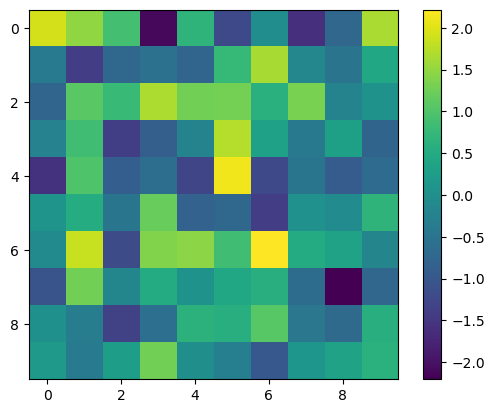

In [3]:
neuron_num = 10
dt = 0.001
tau = 0.3

spike_neuron_num = 2
spike_input = 5

weight_scale = 1
init_scale = 1

total_time = 30000
random_seed = 42

weight_type = "random"

train_data_size = 20000
window_size = 200
batch_size = 32

trainloader, validloader, weight_matrix = data.generate_simulation_data(
    neuron_num=neuron_num,
    dt=dt,
    tau=tau,
    spike_neuron_num=spike_neuron_num,
    spike_input=spike_input,
    weight_scale=weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    random_seed=random_seed,
    weight_type=weight_type,
    train_data_size=train_data_size,
    window_size=window_size,
    batch_size=batch_size,
    data_type = "baseline_2",
    predict_window_size=10,
)

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

In [11]:
model = baselines.Baseline_2()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

checkpoint_path = "../../checkpoints/baseline_2/random_weight/epoch=354-step=266250.ckpt"
results = trainer.predict(model, dataloaders=[validloader], ckpt_path=checkpoint_path)
results = torch.cat(results, dim=0)
print(results.shape)
y_hat = results[:, 0:10]
y = results[:, 10:]

# Get MSE
mse = F.mse_loss(y_hat, y, reduction="mean")
print(mse)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ../../checkpoints/baseline_2/random_weight/epoch=354-step=266250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at ../../checkpoints/baseline_2/random_weight/epoch=354-step=266250.ckpt


Predicting DataLoader 0: 100%|██████████| 188/188 [00:00<00:00, 425.48it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  2663           	|  1.7365         	

torch.Size([5999, 20])
tensor(0.0420)


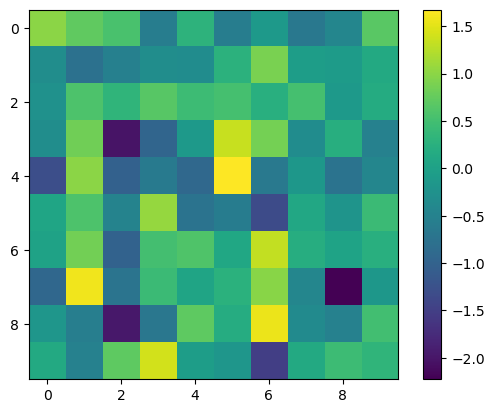

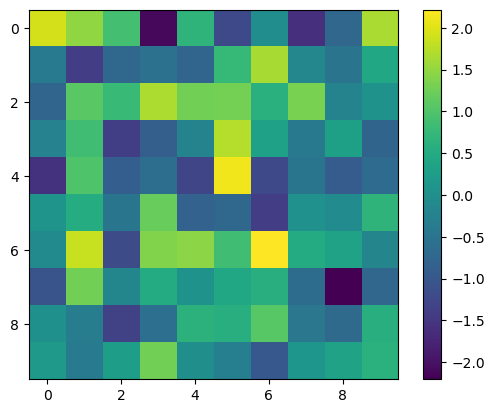

0.8957231221986293


In [20]:
# Get the W linear transformation from the checkpoint
model_checkpoint = model.load_from_checkpoint(checkpoint_path)
W = model_checkpoint.W.weight.data

plt.imshow(W.cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(weight_matrix.detach().numpy())
plt.colorbar()
plt.show()

estimated_weight_matrix = W.cpu().detach().numpy().reshape(-1,)
ground_truth_weight_matrix = weight_matrix.detach().numpy().reshape(-1,)
# compute the correlation
corr = stats.pearsonr(estimated_weight_matrix, ground_truth_weight_matrix).statistic
print(corr)